Elisa Stabilini - 28326A

# Esperienza 4 - Global Warming

Nested samples.
In queste librerie è essenziale la scelta del prior, deve essere fatta con molta attenzione (NB: il prior deve essere normalizzato), altrimenti  non posso calcolare la evidence.

In realtà il prior non la posso inserire direttamente ma bisogna applicare una trasformazione.

$P(D|\Theta$) Likelihood, non fornisco il prior $P(\Theta)$ ma fornisco una trasformazione $$f:[0,1]^N \rightarrow \mathbb{R}^N$$.

Voglio una $y=f(x)$ t.c se $x \sim U_{[0,1]} \rightarrow y \sim P_y$. Per fare questa cosa si utilizzano i quantili e in sostanza ottendo una $y=P_y^{-1}$.

Se ho prior che sono fattorizzabili allora la trasformazione sarà il prodotto delle trasformazioni.

**Processo gaussiano GP**

In maniera informale può essere pensata come una distribuzione sullo spazio delle funzioni ma anche come interpolazione-

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.integrate as integrate
import ultranest as unst
import george as Gg

from typing import List
from collections import Counter
from scipy.integrate import solve_ivp
from scipy.stats import trim_mean
import statsmodels
from statsmodels import robust

from tqdm import tqdm
%matplotlib inline

In [2]:
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

**Upload dei dati**

In [3]:
f = open('/home/elisa/Downloads/Land_and_Ocean_complete.txt','r')
contents = f.readlines()

In [4]:
print(type(contents))

<class 'list'>


In [5]:
rawdata = contents[3:]
lst = [x.strip().split()[:12] for x in rawdata]

In [6]:
data = pd.DataFrame(columns=["Year", "Month", "Anomaly_1m", "Uncertainty_1m", "Anomaly_1", "Uncertainty1_", "Anomaly_5", "Uncertainty_5", "Anomaly_10", "Uncertainty_10", "Anomaly_20", "Uncertainty_20"], data=lst)

In [7]:
data.head(3)

,Year,Month,Anomaly_1m,Uncertainty_1m,Anomaly_1,Uncertainty1_,Anomaly_5,Uncertainty_5,Anomaly_10,Uncertainty_10,Anomaly_20,Uncertainty_20
0,1850,1,-0.769,0.367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1850,2,-0.227,0.505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1850,3,-0.374,0.308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.to_csv("data.csv")

In [9]:
data = pd.read_csv("datanuovo.csv")

In [10]:
data.head(5)

,Unnamed: 0,Year,Month,Anomaly_1m,Uncertainty_1m,Anomaly_1,Uncertainty1_,Anomaly_5,Uncertainty_5,Anomaly_10,Uncertainty_10,Anomaly_20,Uncertainty_20
0,0,1850,1,-0.769,0.367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1850,2,-0.227,0.505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1850,3,-0.374,0.308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1850,4,-0.591,0.384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1850,5,-0.623,0.277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
Temperature ={"Anno": data["Year"], "Anomalia_mese":data["Anomaly_1m"], "Incer_mese": data["Uncertainty_1m"], "Anomalia_anno":data["Anomaly_1"], "Incer_anno":data["Uncertainty1_"]}

## Creazione del modello

Per prima cosa studiamo il funzionamento della libreria


In [12]:
data.loc[data["Anomaly_1m"] == 'Nan', "Anomaly_1m"] = '0'
data = data.drop(data[data.index > 2070].index)

In [13]:
t = np.array(data["Year"])
anomalia_mese = np.array(data["Anomaly_1m"])
err_mese = np.array(data["Uncertainty_1m"])

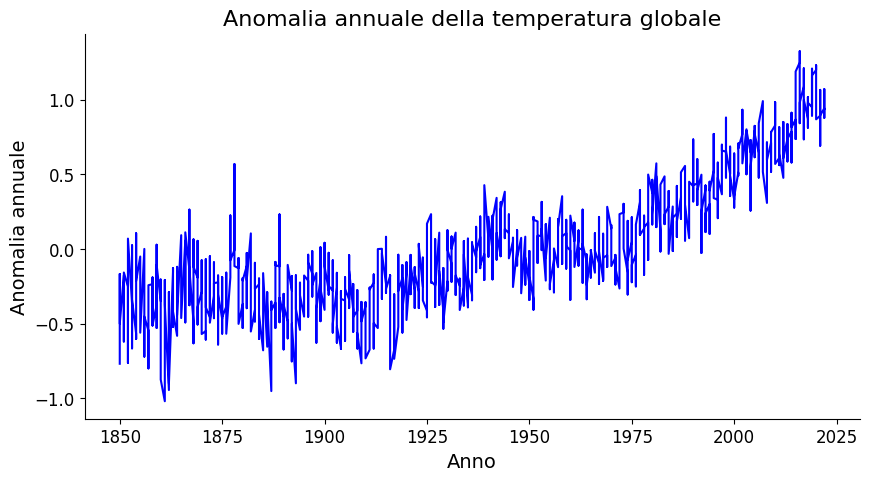

In [14]:
plt.figure(figsize=(10,5))
plt.plot(t,anomalia_mese,color='blue')
plt.xlabel('Anno')
plt.ylabel('Anomalia annuale')
plt.title('Anomalia annuale della temperatura globale')
plt.show()

In [18]:
#prior
parametersConst = ['A']
def prior_transformConst(cube):
    # the argument, cube, consists of values from 0 to 1
    params = cube.copy()
    params[0] = cube[0] * 2
    return params

parametersRetta = ['A', 'B']
def prior_transformRetta(cube):
    # the argument, cube, consists of values from 0 to 1
    params = cube.copy()
    params[0] = cube[0] *50 -25
    params[1] = cube[1] *10

    return params

parametersExp = ['A', 'B', 'C']
def prior_transformExp(cube):
    # the argument, cube, consists of values from 0 to 1
    params = cube.copy()
    params[0] = cube[0] * 5
    params[1] = cube[1] * 4
    params[2] = cube[2] * 20 - 10
    return params

parametersFour = ['A', 'B', 'C', 'D', 'E']
def prior_transformFour(cube):
    params = cube.copy()
    params[0] = cube[0]*50 - 25
    params[1] = cube[1]*100 - 25
    params[2] = cube[2]*100 - 25
    params[3] = cube[3]*100 - 25
    params[4] = cube[4]*100 - 25    

In [19]:
#likelihood
def log_likelihoodConst(cube):
    A, = cube
    
    y_model = A
    loglike = -0.5 * (((y_model - anomalia_mese) / err_mese)**2).sum()
    
    return loglike

def log_likelihoodRetta(cube):
    A,B = cube

    y_model = A + B*t    
    loglike = -0.5 * (((y_model - anomalia_mese) / err_mese)**2).sum()

    return loglike

def log_likelihoodExp(cube):
    A,B,C = cube

    y_model = A*np.exp(B*t/100)+C
    loglike = -0.5 * (((y_model - anomalia_mese/100) / err_mese)**2).sum()

    return loglike

def log_likelihoodFour(cube):
    A,B,C,D,E = cube
    y_model = A + B*t + C**2*t + D**3*t + E**4*t
    loglike = -0.5 * (((y_model - anomalia_mese) / err_mese)**2).sum()

In [20]:
#ultranest

samplerConst = unst.ReactiveNestedSampler(parametersConst, log_likelihoodConst, prior_transformConst)
resultConst = samplerConst.run(min_num_live_points=400)
samplerConst.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+04  -40321.17 [-40321.1691..-40321.1691]*| it/evals=3800/4337 eff=96.5202% N=400  
[ultranest] Likelihood function evaluations: 4360
[ultranest]   logZ = -4.033e+04 +- 0.09787
[ultranest] Effective samples strategy satisfied (ESS = 1222.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.10 tail:0.04 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -40327.425 +- 0.198
  single instance: logZ = -40327.425 +- 0.121
  bootstrapped   : logZ = -40327.424 +- 0.195
  tail           : logZ = +- 0.036
insert order U test : converged: True correlation: inf iterations

    A                   : 0.3515│ ▁▁▁▁▁▁▁▁▁▁▂▃▃▅▅▆▇▇▇▆▅▅▄▃▂▂▁▁▁▁▁▁    ▁ │0.3636    0.3574 +- 0.0014



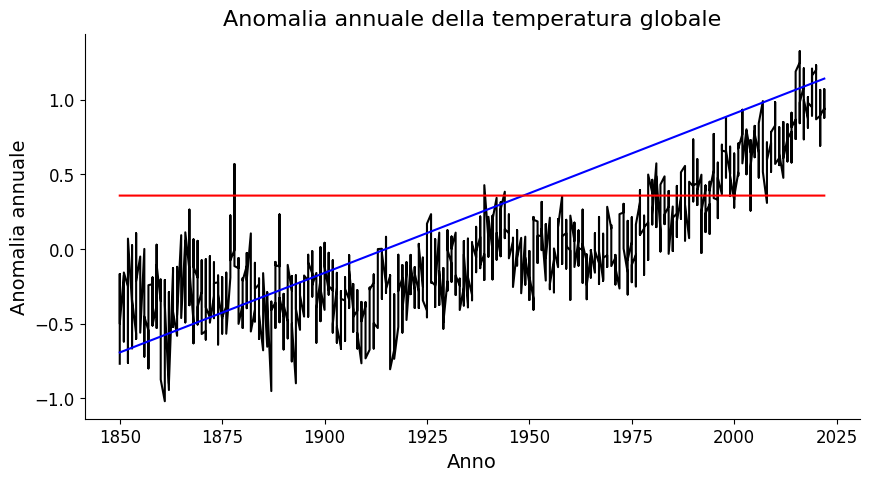

In [21]:
retta=-20.420+0.010663*t
const= 0.3572 + 0*t
plt.figure(figsize=(10,5))
plt.plot(t,anomalia_mese,color='black')
plt.plot(t,retta,color='blue')
plt.plot(t,const,color='red')
plt.xlabel('Anno')
plt.ylabel('Anomalia annuale')
plt.title('Anomalia annuale della temperatura globale')
plt.show()

In [22]:
samplerExp = unst.ReactiveNestedSampler(parametersExp, log_likelihoodExp, prior_transformExp)
resultExp = samplerExp.run(min_num_live_points=400)
samplerExp.print_results()

[ultranest] Sampling 400 live points from prior ...


/home/elisa/miniconda3/lib/python3.9/site-packages/ultranest/integrator.py:1756: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-1  06 [-1.1334..-1.1334]*| it/evals=7895/6190112 eff=0.1276% N=400 
[ultranest] Likelihood function evaluations: 6190112
[ultranest]   logZ = -16.24 +- 0.146
[ultranest] Effective samples strategy satisfied (ESS = 1648.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -16.254 +- 0.253
  single instance: logZ = -16.254 +- 0.188
  bootstrapped   : logZ = -16.235 +- 0.253
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A                   : 0.0   │▇▅▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│5.0       1.5 +- 1.4
    B                   : 0.000 │▇▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ │0.150     0.017 +- 0.022
    C                   : -5.6  │ ▁▁▁▁▁▁▁▁

In [22]:
samplerConst = unst.ReactiveNestedSampler(parametersFour, log_likelihoodFour, prior_transformFour)
resultConst = samplerConst.run(min_num_live_points=400)
samplerConst.print_results()

IndexError: index 1 is out of bounds for axis 0 with size 1

Model comparison:

quello che vogliamo determinare è qual è il modello che descrive meglio i dati noti, per questo motivo si utilizzano tecniche di confronto tra distribuzione di probabilità sfruttando sempre l'analisi Bayesiana NB: questa cosa non la posso fare se utilizzo qualcosa di diverso dal teorema di Bayes.